## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [1]:
!chmod 600 .s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=.s3_passwd -o ro

chmod: cannot access '.s3_passwd': No such file or directory
/bin/bash: line 1: s3fs: command not found


Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [4]:
!ls mnt/

Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [7]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

--2024-04-20 11:55:43--  https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63042 (62K) [text/csv]
Saving to: ‘data/geo_dataframe.csv.1’

geo_dataframe.csv.1 100%[===================>]  61.56K  --.-KB/s    in 0.04s   

2024-04-20 11:55:43 (1.51 MB/s) - ‘data/geo_dataframe.csv.1’ saved [63042/63042]

--2024-04-20 11:55:43--  https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66826127 (64M) [text/csv]
Saving to: ‘data/train_users.csv.1’

train_users.csv.1   100%[===================>]  63.73M  

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [8]:
import pandas as pd

geo = pd.read_csv('data/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


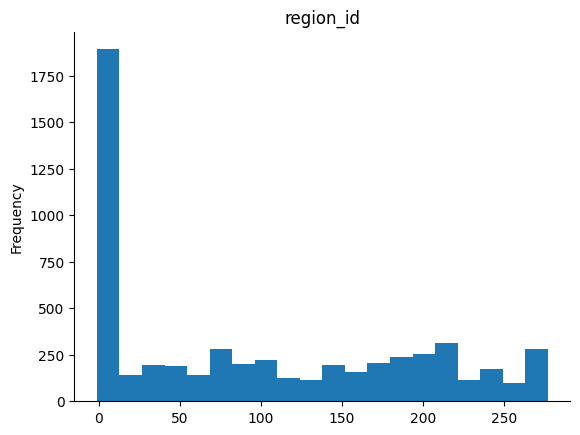

In [9]:
# @title region_id

from matplotlib import pyplot as plt
geo['region_id'].plot(kind='hist', bins=20, title='region_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [11]:
users = pd.read_csv('data/train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<AxesSubplot: xlabel='gender'>

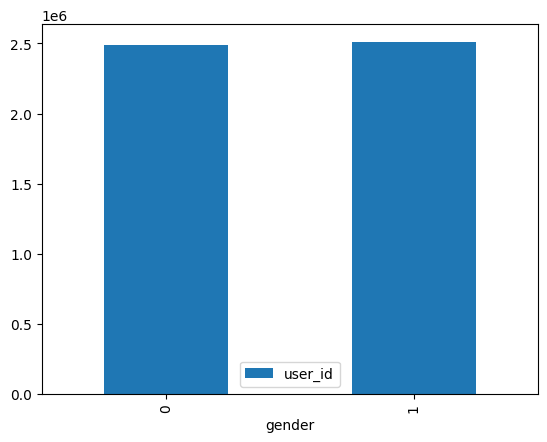

In [ ]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [17]:
req1 = pd.read_parquet('data/requests/part_1.parquet')
req1["user_agent"]

'Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Mobile Safari/537.36'

## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

In [14]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# Setting Workflow

In [92]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
import warnings

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import PIL
%matplotlib inline


rcParams['figure.figsize'] = (15,4)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
!pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 2.4 MB/s eta 0:00:00


# NN Architecture

In [180]:
class MuratNet(nn.Module):
  def __init__(self, input_layer):
    super().__init__()

    self.layer1 = nn.Sequential(
      nn.BatchNorm1d(num_features=input_layer),
      nn.Linear(in_features=input_layer, out_features=64),
      nn.ReLU(inplace=False)
    )

    self.layer2 = nn.Sequential(
      nn.BatchNorm1d(num_features=64),
      nn.Linear(in_features=64, out_features=256),
      nn.ReLU(inplace=False)
    )

    self.layer3 = nn.Sequential(
      nn.BatchNorm1d(num_features=256),
      nn.Linear(in_features=256, out_features=256),
      nn.ReLU(inplace=False)
    )

    self.layer4 = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(in_features=256, out_features=256),
      nn.ReLU(inplace=False)
    )

    self.layer5 = nn.Sequential(
      nn.BatchNorm1d(num_features=256),
      nn.Linear(in_features=256, out_features=64),
      nn.ReLU(inplace=False)
    )

    self.layer6 = nn.Sequential(
      nn.BatchNorm1d(num_features=64),
      nn.Linear(in_features=64, out_features=1)
    )


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.layer6(x)

    return x


# DataSet Wraper

In [13]:
class ReqDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()

    self.files = sorted(files)
    self.mode = mode

    self.len_ = len(self.files)

  def __len__(self):
    return self.len_

  def __getitem__(self, index):
    pass


# Training Cycles

In [28]:
a = np.zeros((2, 10))
a[1, :] += np.ones(10)
a[1, :]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
import telebot

API_TOKEN = "6959275444:AAGUIhrnjrkKzN8P7GXPF6tVeDqJSztbsKI"

bot = telebot.TeleBot(API_TOKEN)
mine_id = 901500807
bot.send_message(chat_id=mine_id, text="Ready to Ignite");


In [172]:
def fit_epoch(model, train_loader, loss_fn_mse, loss_fn_cel, optimizer):
  model.train()

  loss_mse = 0
  loss_cel = 0
  RSS = 0
  TSS = 0
  running_corrects = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss_mse = loss_fn_mse(outputs[:, 0], labels[:, 0])
    loss_cel = loss_fn_cel(outputs[:, 1], labels[:, 1])
    total_loss = 0.5 * loss_mse + 0.5 * loss_cel

    total_loss.backward()
    optimizer.step()


    RSS += torch.sum(torch.abs(labels[:, 0] - outputs[:, 0])).item()
    TSS += torch.sum(torch.abs(labels[:, 0] - outputs[:, 0].mean())).item()

    running_corrects += torch.sum(torch.round(torch.sigmoid(F.softmax(outputs[:, 1]))) == labels[:, 1])
    processed_data += inputs.size(0)


  R2 = 1 - RSS/TSS
  train_acc = running_corrects.cpu().numpy() / processed_data
  return loss_mse, loss_cel, R2, train_acc

In [173]:
def eval_epoch(model, val_loader, loss_fn_mse, loss_fn_cel):
  model.eval()

  loss_mse = 0
  loss_cel = 0
  RSS = 0
  TSS = 0
  running_corrects = 0
  processed_data = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          loss_mse = loss_fn_mse(outputs[:, 0], labels[:, 0])
          loss_cel = loss_fn_cel(outputs[:, 1], labels[:, 1])
          total_loss = 0.5 * loss_mse + 0.5 * loss_cel


          RSS += torch.sum(torch.abs(labels[:, 0] - outputs[:, 0])).item()
          TSS += torch.sum(torch.abs(labels[:, 0] - outputs[:, 0].mean())).item()

          running_corrects += torch.sum(torch.round(torch.sigmoid(F.softmax(outputs[:, 1]))) == labels[:, 1])
          processed_data += inputs.size(0)


  R2 = 1 - RSS/TSS
  train_acc = running_corrects.cpu().numpy() / processed_data
  return R2, train_acc

In [202]:
def train(train_X, train_y, val_X, val_y, model, epochs, batch_size):
    train_loader = DataLoader(list(zip(train_X, train_y)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(list(zip(val_X, val_y)), batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_R2: {t_R2:0.4f} \
    train_acc {t_acc:0.4f} val_R2 {v_R2:0.4f} val_acc {v_acc:0.4f}"
    message_template = "Epoch: {ep:03d}/{eps:03d} training_R2 {t_R2:0.4f} \
    train_accuracy {t_acc:0.4f} validation_R2 {v_R2:0.4f} validation_accuracy {v_acc:0.4f}"
    best_acc = 0
    best_model_wts = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        loss_fn_mse = nn.MSELoss()  # Mean Square Error
        loss_fn_cel = nn.CrossEntropyLoss()  # Cross Entropy Loss

        for epoch in range(epochs):
            loss_mse, loss_cel, train_R2, train_acc = fit_epoch(model, train_loader,\
                                                      loss_fn_mse, loss_fn_cel,\
                                                      opt)
            # print("R2", train_R2)

            val_R2, val_acc = eval_epoch(model, val_loader, loss_fn_mse, loss_fn_cel)
            history.append((train_R2, val_R2, train_acc, val_acc))

            if val_R2 > best_acc:
                best_acc = val_R2
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_R2=train_R2,\
                                           v_R2=val_R2, t_acc=train_acc,\
                                           v_acc=val_acc))
            bot.send_message(chat_id=mine_id,\
                             text=message_template.format(ep=epoch + 1,\
                                                          eps=epochs,\
                                                          t_R2=train_R2,\
                                                          v_R2=val_R2,\
                                                          t_acc=train_acc,\
                                                          v_acc=val_acc))

    model.load_state_dict(best_model_wts)
    return model, history

# Training

In [61]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [62]:
!ls

gdrive	sample_data


In [39]:
import pandas as pd

In [63]:
df = pd.read_parquet('gdrive/MyDrive/with_type-3.parquet')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431338 entries, 0 to 449412
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestamp   431338 non-null  int64  
 1   user_id     431338 non-null  int32  
 2   gender      431338 non-null  float64
 3   age         431338 non-null  float64
 4   region_id   431338 non-null  int64  
 5   country_id  431338 non-null  int64  
 6   domain      431338 non-null  int64  
 7   path        431338 non-null  int64  
 8   is_email    431338 non-null  int64  
 9   is_mobile   431338 non-null  int64  
 10  is_pc       431338 non-null  int64  
 11  is_tablet   431338 non-null  int64  
 12  path_count  431338 non-null  int64  
dtypes: float64(2), int32(1), int64(10)
memory usage: 44.4 MB


In [66]:
y = df[["age", "gender"]]
X = df.drop(["age", "gender"], axis=1)

In [157]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32) # .reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32) # .reshape(-1, 1)


# training parameters
n_epochs = 10   # number of epochs to run
bt = 100  # size of each batch
md = MuratNet(input_layer=11)
md.to(device)

MuratNet(
  (layer1): Sequential(
    (0): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=11, out_features=64, bias=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
  )
  (layer6): Sequential(
    (0): BatchNorm1d(64, eps=1e-05, momentu

In [203]:
from tqdm import tqdm
import torch.nn.functional as F

best_model, history = train(X_train, y_train, X_test, y_test, model=md, epochs=n_epochs, batch_size=bt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: fit_epoch() takes 4 positional arguments but 5 were given

In [205]:
print(f"val_acc: {0.56}\nval_R2: {0.104}")

val_acc: 0.56
val_R2: 0.104


# Sep Training

In [188]:
def fit_epoch_mse(model, train_loader, loss_fn, optimizer):
  model.train()

  RSS = 0
  TSS = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels[:, 0])
    loss.backward()
    optimizer.step()


    RSS += torch.sum(torch.abs(labels[:, 0] - outputs)).item()
    TSS += torch.sum(torch.abs(labels[:, 0] - outputs.mean())).item()

  R2 = 1 - RSS/TSS
  return R2

In [190]:
def fit_epoch_cel(model, train_loader, loss_fn, optimizer):
  model.train()

  running_corrects = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels[:, 0])
    loss.backward()
    optimizer.step()


    running_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels[:, 1])
    processed_data += inputs.size(0)

  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_acc

In [198]:
def eval_epoch_mse(model, val_loader, loss_fn):
  model.eval()

  running_corrects = 0
  processed_data = 0
  RSS = 0
  TSS = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          loss = loss_fn(outputs, labels[:, 1])

          RSS += torch.sum(torch.abs(labels[:, 0] - outputs)).item()
          TSS += torch.sum(torch.abs(labels[:, 0] - outputs.mean())).item()

  R2 = 1 - RSS/TSS
  return R2

In [191]:
def eval_epoch_cel(model, val_loader, loss_fn):
  model.eval()

  running_corrects = 0
  processed_data = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          loss = loss_fn(outputs[:, 1], labels[:, 1])

          running_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels[:, 1])
          processed_data += inputs.size(0)


  val_acc = running_corrects.cpu().numpy() / processed_data
  return val_acc

In [201]:
def train2(train_X, train_y, val_X, val_y, model1, model2, epochs, batch_size):
    train_loader_1 = DataLoader(list(zip(train_X, train_y)), batch_size=batch_size, shuffle=True)
    val_loader_1 = DataLoader(list(zip(val_X, val_y)), batch_size=batch_size, shuffle=False)

    train_loader_2 = DataLoader(list(zip(train_X, train_y)), batch_size=batch_size, shuffle=True)
    val_loader_2 = DataLoader(list(zip(val_X, val_y)), batch_size=batch_size, shuffle=False)


    history = []
    log_template = "\nEpoch {ep:03d} train_R2: {t_R2:0.4f} \
    train_acc {t_acc:0.4f} val_R2 {v_R2:0.4f} val_acc {v_acc:0.4f}"
    message_template = "Epoch: {ep:03d}/{eps:03d} training_R2 {t_R2:0.4f} \
    train_accuracy {t_acc:0.4f} validation_R2 {v_R2:0.4f} validation_accuracy {v_acc:0.4f}"
    best_acc = 0
    best_r2 = 0
    best_model1_wts = 0
    best_model2_wts = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt1 = torch.optim.Adam(model1.parameters())
        opt2 = torch.optim.Adam(model2.parameters())
        loss_fn_mse = nn.MSELoss()  # Mean Square Error
        loss_fn_cel = nn.CrossEntropyLoss()  # Cross Entropy Loss

        for epoch in range(epochs):
            train_R2 = fit_epoch_mse(model1, train_loader_1,\
                                  loss_fn_mse,\
                                  opt1)
            '''
            train_acc = fit_epoch_cel(model2, train_loader_2,\
                                  loss_fn_cel,\
                                  opt2)
            '''

            val_R2 = eval_epoch_mse(model1, val_loader_1, loss_fn_mse)
            # val_acc = eval_epoch_cel(model2, val_loader_2, loss_fn_cel)
            val_acc = 0
            train_acc = 0

            history.append((train_R2, val_R2, train_acc, val_acc))

            if val_R2 > best_r2:
                best_r2 = val_R2
                best_model1_wts = model1.state_dict()
            if val_acc > best_acc:
                best_acc = val_R2
                best_model2_wts = model2.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_R2=train_R2,\
                                           v_R2=val_R2, t_acc=train_acc,\
                                           v_acc=val_acc))
            bot.send_message(chat_id=mine_id,\
                             text=message_template.format(ep=epoch + 1,\
                                                          eps=epochs,\
                                                          t_R2=train_R2,\
                                                          v_R2=val_R2,\
                                                          t_acc=train_acc,\
                                                          v_acc=val_acc))

    model1.load_state_dict(best_model1_wts)
    model2.load_state_dict(best_model2_wts)
    return model1, model2, history

In [199]:
from tqdm import tqdm
import torch.nn.functional as F


# training parameters
n_epochs = 10   # number of epochs to run
bt = 100  # size of each batch
md1 = MuratNet(input_layer=11)
md1.to(device)

md2 = MuratNet(input_layer=11)
md2.to(device)

best_model1, best_model2, history = train(X_train, y_train, X_test, y_test, model1=md1, model2=md2, epochs=n_epochs, batch_size=bt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:  10%|█         | 1/10 [00:15<02:16, 15.18s/it]


Epoch 001 train_R2: -98.9945     train_acc 0.0000 val_R2 -98.9992 val_acc 0.0000


epoch:  20%|██        | 2/10 [00:30<02:00, 15.08s/it]


Epoch 002 train_R2: -98.9926     train_acc 0.0000 val_R2 -98.9992 val_acc 0.0000


epoch:  30%|███       | 3/10 [00:44<01:43, 14.85s/it]


Epoch 003 train_R2: -98.9922     train_acc 0.0000 val_R2 -98.9992 val_acc 0.0000


epoch:  40%|████      | 4/10 [00:59<01:28, 14.80s/it]


Epoch 004 train_R2: -98.9932     train_acc 0.0000 val_R2 -98.9992 val_acc 0.0000


epoch:  50%|█████     | 5/10 [01:14<01:13, 14.72s/it]


Epoch 005 train_R2: -98.9938     train_acc 0.0000 val_R2 -98.9994 val_acc 0.0000


epoch:  60%|██████    | 6/10 [01:28<00:58, 14.72s/it]


Epoch 006 train_R2: -98.9923     train_acc 0.0000 val_R2 -99.0006 val_acc 0.0000


epoch:  70%|███████   | 7/10 [01:45<00:45, 15.23s/it]


Epoch 007 train_R2: -98.9913     train_acc 0.0000 val_R2 -98.9993 val_acc 0.0000


epoch:  80%|████████  | 8/10 [02:00<00:30, 15.14s/it]


Epoch 008 train_R2: -98.9926     train_acc 0.0000 val_R2 -99.0596 val_acc 0.0000


epoch:  90%|█████████ | 9/10 [02:14<00:15, 15.07s/it]


Epoch 009 train_R2: -98.9937     train_acc 0.0000 val_R2 -99.1887 val_acc 0.0000


epoch: 100%|██████████| 10/10 [02:29<00:00, 14.99s/it]


Epoch 010 train_R2: -98.9923     train_acc 0.0000 val_R2 -99.0015 val_acc 0.0000


TypeError: Expected state_dict to be dict-like, got <class 'int'>.